In [1]:
from model import *

In [2]:
# helper functions

def count_snowballs(t,snowball):
    transitions = [i for i in range(1, len(snowball)) if snowball[i] and not snowball[i - 1]]
    return len(transitions)

def longest_snowball(t,snowball):
    snowball_starts, snowball_ends, snowball_durations, interglacial_durations = get_times(t, snowball)
    return np.max(snowball_durations)

In [3]:
def find_C_imb_threshold(params=None, lo=0, hi=1, tol=0.01, max_iter=30, verbose=True):
    lo_guess, hi_guess = lo, hi
    iterations = 0
    guess = None

    while (hi_guess - lo_guess) > tol and iterations < max_iter:
        guess = (lo_guess + hi_guess) / 2
        params['C_imb'] = guess

        results = run_model(**params)
        snowballs = count_snowballs(results['t'], results['snowball'])

        if verbose:
            print(f"C_imb: {guess:.3f}, cycles: {snowballs}")

        if snowballs > 0:
            hi_guess = guess
        else:
            lo_guess = guess

        iterations += 1

    if hi_guess is not None:
        print(f"Final C_imb threshold: {hi_guess:.3f}")

    return guess


In [6]:
threshold = find_C_imb_threshold({"n":0.2,"V_C":8.5,"W_sea":1.6,"dt":1e4/1e6,"t_max":56})

C_imb: 0.500, cycles: 4
C_imb: 0.250, cycles: 0
C_imb: 0.375, cycles: 0
C_imb: 0.438, cycles: 0
C_imb: 0.469, cycles: 4
C_imb: 0.453, cycles: 0
C_imb: 0.461, cycles: 3
Final C_imb threshold: 0.461


### sweep

In [7]:
# For each value of param_name, find the minimum C_imb to trigger limit cycles

def sweep_param_thresholds(param_name, param_values,
                           base_params,
                           lo=0, hi=10, tol=0.01,
                           max_iter=30,
                           verbose=True):
    thresholds = []
    base_kwargs = base_params.copy()
    base_kwargs['verbose'] = False

    for val in param_values:
        if verbose:
            print(f"{param_name}: {val}")

        lo_guess, hi_guess = lo, hi
        iterations = 0
        base_kwargs[param_name] = val

        try:
            while (hi_guess - lo_guess) > tol and iterations < max_iter:
                guess = (lo_guess + hi_guess) / 2
                run_kwargs = base_kwargs.copy()
                run_kwargs.update({'C_imb': guess})
                results = run_model(**run_kwargs)

                t = results['t']
                snowball = results['snowball']
                snowballs = count_snowballs(t, snowball)

                if verbose:
                    print(f"    C_imb: {guess:.3f}, cycles: {snowballs}")

                if snowballs > 0:
                    hi_guess = guess
                else:
                    lo_guess = guess

                iterations += 1

            thresholds.append(hi_guess)
            if verbose:
                print(f"    final C_imb threshold: {hi_guess:.3f}")

        except ValueError as e:
            if "W_org" in str(e):
                if verbose:
                    print("    Skipping due to ValueError: initial W_org is negative.")
                thresholds.append(np.nan)
                continue
            else:
                raise

    return param_values, thresholds


In [8]:
# Base model parameters
params = {'t_max': 56, 'V_red':0, 'dt':1e4/1e6}

# Store results
sweep_results = {}

In [9]:
param_name = 'n'
param_values = np.linspace(0,1,20)
xvals, yvals = sweep_param_thresholds(param_name, param_values, params)
sweep_results[param_name] = [xvals, yvals]

n: 0.0
    C_imb: 5.000, cycles: 9
    C_imb: 2.500, cycles: 6
    C_imb: 1.250, cycles: 4
    C_imb: 0.625, cycles: 2
    C_imb: 0.312, cycles: 1
    C_imb: 0.156, cycles: 1
    C_imb: 0.078, cycles: 1
    C_imb: 0.039, cycles: 1
    C_imb: 0.020, cycles: 1
    C_imb: 0.010, cycles: 0
    final C_imb threshold: 0.020
n: 0.05263157894736842
    C_imb: 5.000, cycles: 9
    C_imb: 2.500, cycles: 7
    C_imb: 1.250, cycles: 5
    C_imb: 0.625, cycles: 3
    C_imb: 0.312, cycles: 3
    C_imb: 0.156, cycles: 2
    C_imb: 0.078, cycles: 0
    C_imb: 0.117, cycles: 0
    C_imb: 0.137, cycles: 2
    C_imb: 0.127, cycles: 1
    final C_imb threshold: 0.127
n: 0.10526315789473684
    C_imb: 5.000, cycles: 10
    C_imb: 2.500, cycles: 7
    C_imb: 1.250, cycles: 6
    C_imb: 0.625, cycles: 4
    C_imb: 0.312, cycles: 3
    C_imb: 0.156, cycles: 0
    C_imb: 0.234, cycles: 0
    C_imb: 0.273, cycles: 3
    C_imb: 0.254, cycles: 2
    C_imb: 0.244, cycles: 2
    final C_imb threshold: 0.244
n: 0.15

In [10]:
# actually V_C minus W_sea
param_name = 'V_C'
special_params = params | {'W_sea':0}
param_values = np.linspace(6.5-2.4,10.5,20)
xvals, yvals = sweep_param_thresholds(param_name, param_values, special_params)
sweep_results[param_name] = [xvals, yvals]

V_C: 4.1
    C_imb: 5.000, cycles: 8
    C_imb: 2.500, cycles: 6
    C_imb: 1.250, cycles: 5
    C_imb: 0.625, cycles: 4
    C_imb: 0.312, cycles: 3
    C_imb: 0.156, cycles: 0
    C_imb: 0.234, cycles: 0
    C_imb: 0.273, cycles: 2
    C_imb: 0.254, cycles: 0
    C_imb: 0.264, cycles: 0
    final C_imb threshold: 0.273
V_C: 4.436842105263158
    C_imb: 5.000, cycles: 8
    C_imb: 2.500, cycles: 7
    C_imb: 1.250, cycles: 5
    C_imb: 0.625, cycles: 4
    C_imb: 0.312, cycles: 3
    C_imb: 0.156, cycles: 0
    C_imb: 0.234, cycles: 0
    C_imb: 0.273, cycles: 0
    C_imb: 0.293, cycles: 2
    C_imb: 0.283, cycles: 0
    final C_imb threshold: 0.293
V_C: 4.773684210526316
    C_imb: 5.000, cycles: 9
    C_imb: 2.500, cycles: 7
    C_imb: 1.250, cycles: 6
    C_imb: 0.625, cycles: 4
    C_imb: 0.312, cycles: 0
    C_imb: 0.469, cycles: 4
    C_imb: 0.391, cycles: 4
    C_imb: 0.352, cycles: 3
    C_imb: 0.332, cycles: 3
    C_imb: 0.322, cycles: 3
    final C_imb threshold: 0.322
V_C: 5

In [11]:
from matplotlib import rcParams

rcParams['font.family'] = 'Arial'
rcParams['axes.labelsize'] = 10     # x/y axis labels
rcParams['xtick.labelsize'] = 8     # x-axis tick labels
rcParams['ytick.labelsize'] = 8     # y-axis tick labels
rcParams['legend.fontsize'] = 8     # legend text
rcParams['font.size'] = 8           # default text size (e.g., for ax.text)

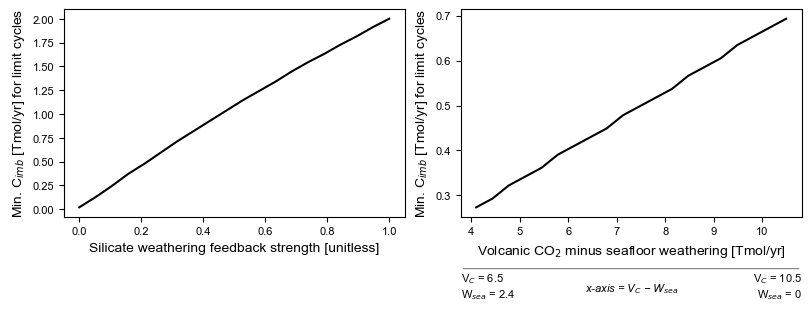

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(8,3), constrained_layout=True)

ax = axs[0]
x,y = sweep_results['n']
ax.plot(x,y,marker='o',c='k',ms=0)
ax.set_xlabel('Silicate weathering feedback strength [unitless]')

ax = axs[1]
x,y = sweep_results['V_C']
ax.plot(x,y,marker='o',c='k',ms=0)
ax.set_xlabel('Volcanic CO$_2$ minus seafloor weathering [Tmol/yr]')

for ax in axs:
    ax.set_ylabel('Min. C$_{imb}$ [Tmol/yr] for limit cycles')

# --- Annotate V_C and W_sea bounds below x-axis of axs[1] ---

x0, x1 = axs[1].get_xlim()

# Adjust vertical position and font size
y_text = -0.25
fontsize = 8

# Horizontal guide line
axs[1].annotate('', xy=(x0, y_text), xycoords=('data', 'axes fraction'),
                xytext=(x1, y_text), textcoords=('data', 'axes fraction'),
                arrowprops=dict(arrowstyle='-', color='gray', linewidth=0.8))

# Endpoint labels
axs[1].annotate('V$_C$ = 6.5\nW$_{sea}$ = 2.4',
                xy=(x0, y_text), xycoords=('data', 'axes fraction'),
                textcoords='offset points', xytext=(0, -2),
                ha='left', va='top', fontsize=fontsize)

axs[1].annotate('V$_C$ = 10.5\nW$_{sea}$ = 0',
                xy=(x1, y_text), xycoords=('data', 'axes fraction'),
                textcoords='offset points', xytext=(0, -2),
                ha='right', va='top', fontsize=fontsize)

# Center label
axs[1].annotate('x-axis = V$_C$ − W$_{sea}$',
                xy=(0.5, y_text - 0.06), xycoords=('axes fraction', 'axes fraction'),
                ha='center', va='top', fontsize=fontsize, style='italic')

figname="Cimb.pdf"
savefig(fig,figname,savefmt='pdf',supp_folder="supp")